Pizza and Steak Binary Classification
---

Utilizing Convlutional Neural Networks (CNN) we'll be creating a binary classification model that will be able to classify between custom images of pizza and steak. An initial basic CNN model is utilized for basic understanding and to formally train a model [Tiny VGG Net](https://poloclub.github.io/cnn-explainer/) will be used.


In [ ]:
# GPU being provided by Google Colab 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  2 01:12:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    37W / 250W |   2191MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Machine type being provided by Google Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
# Importing packages and functions
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import zipfile
import os
import seaborn as sns
import pandas as pd

Image Data
---



Image data being utilized for training has been taken from [Kaggle Food-101](https://www.kaggle.com/datasets/dansbecker/food-101) dataset. It contains 101,000 images for 101 different classes of food types. For our purposes we have extracted only two classes of food images i.e. Pizza and Steak. The training images for each class are 750 and for validation are 250.

In [ ]:
# Importing data:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-01 23:10:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M   135MB/s    in 0.8s    

2022-08-01 23:10:35 (135 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



In [ ]:
# Total directories and images in the aforementioned directories
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in pizza_steak.
There are 2 directories and 0 images in pizza_steak/train.
There are 0 directories and 750 images in pizza_steak/train/steak.
There are 0 directories and 750 images in pizza_steak/train/pizza.
There are 2 directories and 0 images in pizza_steak/test.
There are 0 directories and 250 images in pizza_steak/test/steak.
There are 0 directories and 250 images in pizza_steak/test/pizza.


Dataset Visualization 
---



In [ ]:
# Importing class names to visualize images
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['pizza' 'steak']


In [ ]:
# Custom function for Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  """
  Imports random image from target directory and class
  """

  # Sets the target directory
  target_folder = target_dir + target_class

  # Gets a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  #print(f"Filename = {random_image}")

  # Utilizes file/image data by plotting it in matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape = {img.shape}")

  return img

❗**Each image in the data set is of RGB color spectrum and min resolution for either width/height is 221 and maximum is 512**

Image shape = (512, 512, 3)
Image shape = (512, 384, 3)
Image shape = (512, 512, 3)
Image shape = (512, 512, 3)


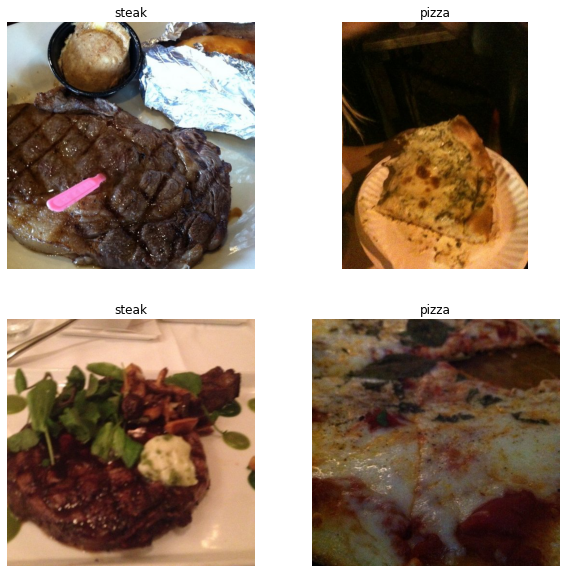

In [ ]:
# Visualize the sample data
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(2,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(2,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")
plt.subplot(2,2,3)
steak_img_2 = view_random_image("pizza_steak/train/", "steak")
plt.subplot(2,2,4)
pizza_img_2 = view_random_image("pizza_steak/train/", "pizza")
plt.show()

Data Preprocessing
---

In CNN and deep learning in general any sort of data which is imported is converted into tensors i.e. numerical encoding which the deep learning model can understand. In case of images, each image is numerically encoded into a tensor. Each image has a layer of color spectrum RGB in each pixel. Each picture when imported is recoded in these RGB values pixel by pixel into a single tensor. 


CNN and generally deep learning models prefer normalization of numerically encoded data. Normalization refers that each value in the tensor is converted to value between 0 and 1. This leads to faster and much accurate training results. Using the function **ImageDataGenerator** we can normalize the image tensors. 

It is also a good practice to divide the data into minibatches especially in the case of CNNs. Using the same function as mentioned above we can generate batches of the data. There are many batch size that can be used but generally it is a good option to use the default size of 32 as advised by [Professor Yann Lecun](https://twitter.com/ylecun/status/989610208497360896?lang=en). Validation data would be also used during each epoch as an additional tool for the model so the model would be able to generalize in a better manner by evluating the weights and biases on images other than it has trained on. Validation images would also be divided into batches. The benefits of dividing the data into minibatches are:
  1. When we are dealing with large datasets the GPU or CPU has to load large chunk of data into its memory in order to compute weights and biases. If the whole dataset is loaded as a whole it might exhaust the memory of the GPU or RAM when using CPU. When data is divided into batches during each epoch data is loaded in the GPU each batch at a time thus reducing the load on GPU significantly. 
  2. If the whole dataset is loaded this might lead to higher losses and reduced accuracy. When the data is loaded as whole weights and biases are recomputed during each epoch. While using minibatches weights and biases for the model are recomputed multiple times during one epoch i.e. equivalent to the number of overall batches. This leads to better training of the model and better results on the validation set as well. 

Images dimensions can also be reduced to a smaller scale for faster processing as less data/pixels would be needed to analyzed during training and validation. The default resoulution of (256 x 256) would be sufficient for Tiny VGG. The resolution can also be changed using the same function. 



In [ ]:
# Data preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale= 1/255.0) 
test_datagen = ImageDataGenerator(rescale = 1/255.0)

train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               target_size = (256,256),
                                               class_mode = "binary",
                                               batch_size = 32,
                                               seed = 42)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                             target_size = (256,256),
                                             class_mode = "binary",
                                             batch_size = 32,
                                             seed = 42)

sample_images, sample_labels = train_data.next()

print(f"Shape of an single image tensor {sample_images[0].shape}")

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Shape of an single image tensor (256, 256, 3)


In [ ]:
# Representation of an normalized image as a single tensor
sample_images[0]

array([[[0.42352945, 0.43137258, 0.34509805],
        [0.31764707, 0.3254902 , 0.2392157 ],
        [0.26666668, 0.28235295, 0.18431373],
        ...,
        [0.41960788, 0.34117648, 0.38431376],
        [0.44705886, 0.3647059 , 0.42352945],
        [0.43921572, 0.35686275, 0.42352945]],

       [[0.2901961 , 0.30588236, 0.21568629],
        [0.45882356, 0.47450984, 0.37647063],
        [0.2627451 , 0.28627452, 0.18431373],
        ...,
        [0.4156863 , 0.35686275, 0.36862746],
        [0.40784317, 0.36078432, 0.37647063],
        [0.38823533, 0.3372549 , 0.3647059 ]],

       [[0.25882354, 0.28235295, 0.18039216],
        [0.4431373 , 0.4666667 , 0.3647059 ],
        [0.28235295, 0.30588236, 0.20392159],
        ...,
        [0.3803922 , 0.34117648, 0.33333334],
        [0.35686275, 0.3254902 , 0.31764707],
        [0.36862746, 0.3372549 , 0.32941177]],

       ...,

       [[0.5137255 , 0.5058824 , 0.54901963],
        [0.5176471 , 0.50980395, 0.5529412 ],
        [0.52156866, 0

Trial Model
---

To ascertain how CNN works a basic CNN model can be used. Some of the hyperparamters in this CNN that are being used are adapted from Tiny VGG. Nevertheless, these give somewhat equivalent results to the Tiny VGG during training and as well as validation. 

  1.RELU in CNN provides the best results to ascertain the decision boundaries as it is a piecewise activation. 

  2.Setting the padding to "valid" reduces the dimension of the images and only ascertains the most prominent feautures from the images. The kernal size of (3,3) will be a balance of finding out the larger features in our case the shape of the Pizza and also the smaller features in case of Steak images.

  3.Binary Crossetropy is used as loss function for binary classification

  4.The final layer is a fully connected dense layer whose neurons can be adjusted as per the number of classes. In case of binary classification only one neuron is used in the output layer. 

  5.Sigmoid activation will be used in the output layer to give prediction probabilities for the class. By default probability of 0.5 will be the decision boundary for the classification.  

**Note the Convolutional and Maxpooling layers can be increases and decreased as per the model that is needed to be generated. One thing to keep in mind is that too many Convolutional layers will lead to the model overfitting during training.**





In [ ]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters= 10, kernel_size= 3, activation= "relu", input_shape = (256,256,3), name = "First_Convolutional_layer"), 
  tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid", name = "First_Maxpool_Layer"), 
  tf.keras.layers.Conv2D(filters= 10, kernel_size= 3, activation= "relu", name = "Second_Convolutional_layer"), 
  tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid", name = "Second_Maxpool_Layer"),
  tf.keras.layers.Conv2D(filters= 10, kernel_size= 3, activation= "relu", name = "Third_Convolutional_layer"),
  tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid", name = "Third_Maxpool_Layer"),
  tf.keras.layers.Flatten(name = "Flatting_layer"),
  tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "output_layer")], name = "Trial_Model")

In [ ]:
model_1.summary()

Model: "Trial_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Convolutional_layer (  (None, 254, 254, 10)     280       
 Conv2D)                                                         
                                                                 
 First_Maxpool_Layer (MaxPoo  (None, 127, 127, 10)     0         
 ling2D)                                                         
                                                                 
 Second_Convolutional_layer   (None, 125, 125, 10)     910       
 (Conv2D)                                                        
                                                                 
 Second_Maxpool_Layer (MaxPo  (None, 62, 62, 10)       0         
 oling2D)                                                        
                                                                 
 Third_Convolutional_layer (  (None, 60, 60, 10)       

In [ ]:
model_1.compile(loss = tf.keras.losses.binary_crossentropy, # Loss for binary classification models
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)) # Default learning rate

In [ ]:
batch_size = 32
print(f"steps per epoch for train data {1500/batch_size}")
print(f"steps per epoch for validation data {500/batch_size}")

print(len(train_data))

print(len(test_data))

steps per epoch for train data 46.875
steps per epoch for validation data 15.625
47
16


In [ ]:
tf.random.set_seed(42)
history_1 = model_1.fit(train_data, epochs = 15, steps_per_epoch= len(train_data),
            validation_data = test_data, validation_steps = len(test_data))

Epoch 1/15
47/47 [==============================] - 12s 230ms/step - loss: 0.5829 - accuracy: 0.7060 - val_loss: 0.5067 - val_accuracy: 0.7420
Epoch 2/15
47/47 [==============================] - 11s 240ms/step - loss: 0.4778 - accuracy: 0.7827 - val_loss: 0.3974 - val_accuracy: 0.8340
Epoch 3/15
47/47 [==============================] - 10s 219ms/step - loss: 0.4222 - accuracy: 0.8093 - val_loss: 0.3299 - val_accuracy: 0.8720
Epoch 4/15
47/47 [==============================] - 10s 217ms/step - loss: 0.3770 - accuracy: 0.8407 - val_loss: 0.3081 - val_accuracy: 0.8760
Epoch 5/15
47/47 [==============================] - 10s 217ms/step - loss: 0.3538 - accuracy: 0.8473 - val_loss: 0.3033 - val_accuracy: 0.8620
Epoch 6/15
47/47 [==============================] - 10s 219ms/step - loss: 0.3344 - accuracy: 0.8500 - val_loss: 0.3272 - val_accuracy: 0.8500
Epoch 7/15
47/47 [==============================] - 10s 219ms/step - loss: 0.3106 - accuracy: 0.8760 - val_loss: 0.2659 - val_accuracy: 0.8940

During training the model tranining and validation loss were decreasing with each epoch but after 10 epochs the model was overfitting. This can be seen with an increase in validation loss. The increase in validation loss is resulting with a decrease in validation accuracy. There are many ways overfitting can be reduced to make the model more generalizable.

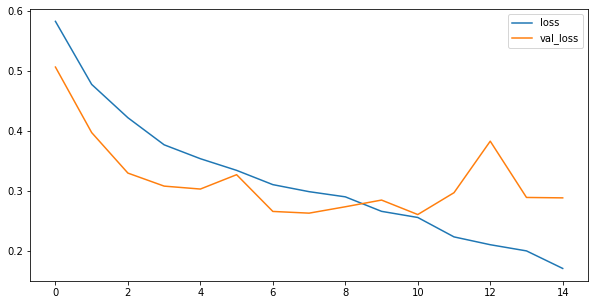

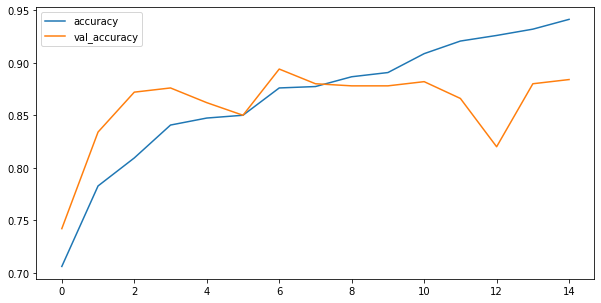

In [ ]:
# Loss Curve
plt.rcParams["figure.figsize"] = (10,5)
losses = pd.DataFrame(history_1.history)[["loss", "val_loss"]].plot()
accuracies = pd.DataFrame(history_1.history)[["accuracy", "val_accuracy"]].plot()

Tiny VGG
---

The model has been taken from [CNN explainer website](https://poloclub.github.io/cnn-explainer/). An early implementation of CNN but gives accurate results where a smaller number of classes are utilized. The model utilized 1400+ more trainable paramaters then the first trial model.



In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
 tf.keras.layers.Conv2D(filters = 10,
                        kernel_size = 3,
                        input_shape = (256,256,3),
                        activation = "relu", name = "first_conv_layer"),
 tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, activation= "relu", name = "second_conv_layer"),
 tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid", name = "first_maxpool_layer"),
 tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, activation= "relu", name = "third_conv_layer"),
 tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, activation= "relu", name = "fourth_conv_layer"),
 tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid", name = "second_maxpool_layer"),
 tf.keras.layers.Flatten(name = "Flattening_layer"),
 tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Output_layer")], name = "Tiny_VGG_V1") # Activation Sigmoid for binary classification

In [ ]:
model_2.summary()

Model: "Tiny_VGG_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_conv_layer (Conv2D)   (None, 254, 254, 10)      280       
                                                                 
 second_conv_layer (Conv2D)  (None, 252, 252, 10)      910       
                                                                 
 first_maxpool_layer (MaxPoo  (None, 126, 126, 10)     0         
 ling2D)                                                         
                                                                 
 third_conv_layer (Conv2D)   (None, 124, 124, 10)      910       
                                                                 
 fourth_conv_layer (Conv2D)  (None, 122, 122, 10)      910       
                                                                 
 second_maxpool_layer (MaxPo  (None, 61, 61, 10)       0         
 oling2D)                                              

In [ ]:
model_2.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ["accuracy"])
tf.random.set_seed(42)
history_2 = model_2.fit(train_data, epochs = 10, steps_per_epoch= len(train_data),
            validation_data = test_data, validation_steps = len(test_data))

Epoch 1/10
47/47 [==============================] - 11s 225ms/step - loss: 0.5791 - accuracy: 0.6933 - val_loss: 0.4643 - val_accuracy: 0.7700
Epoch 2/10
47/47 [==============================] - 10s 220ms/step - loss: 0.4583 - accuracy: 0.7880 - val_loss: 0.3713 - val_accuracy: 0.8480
Epoch 3/10
47/47 [==============================] - 10s 220ms/step - loss: 0.3948 - accuracy: 0.8213 - val_loss: 0.3633 - val_accuracy: 0.8460
Epoch 4/10
47/47 [==============================] - 11s 242ms/step - loss: 0.3740 - accuracy: 0.8467 - val_loss: 0.3112 - val_accuracy: 0.8640
Epoch 5/10
47/47 [==============================] - 10s 221ms/step - loss: 0.3289 - accuracy: 0.8627 - val_loss: 0.3472 - val_accuracy: 0.8500
Epoch 6/10
47/47 [==============================] - 10s 221ms/step - loss: 0.3006 - accuracy: 0.8833 - val_loss: 0.3090 - val_accuracy: 0.8740
Epoch 7/10
47/47 [==============================] - 10s 221ms/step - loss: 0.2319 - accuracy: 0.9080 - val_loss: 0.3289 - val_accuracy: 0.8600

Loss Curves
---

After 10 epochs the model is overfitting as the loss curve for validation is exhibiting a spike i.e. increase in loss while the train loss is going down. 



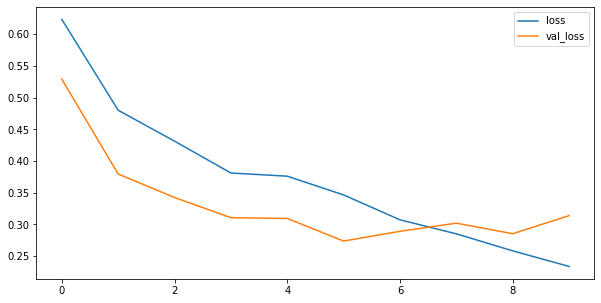

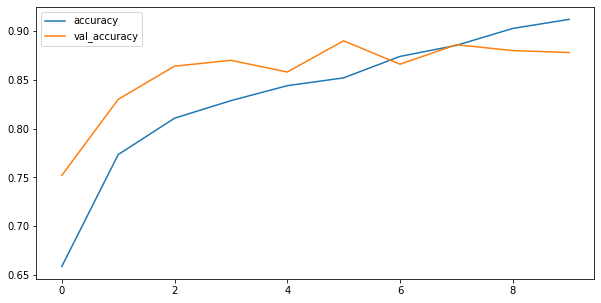

In [ ]:
losses = pd.DataFrame(history_2.history)[["loss", "val_loss"]].plot()
accuracies = pd.DataFrame(history_2.history)[["accuracy", "val_accuracy"]].plot()

Adjustment of learning rate
---

The learning rate during training can affect how quickly can the model reach the global minima during training. A large learning rate would make the step size too large at each epoch while a small learning rate would make the model settle for the local minima, hence not the optimal weights and biases for the model. An optimal/balanced learning rate is required in order to get the optimal results. A schdeuler can be set to see the optimal learning rate. 


In [ ]:
tf.random.set_seed(42)
model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu", input_shape = (256,256,3)),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = "valid"),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = "valid"),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation = "sigmoid")                   
])

# Learning Rate Callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

# Compile the model 
model_0.compile(loss = tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])


history_0 = model_0.fit(train_data, steps_per_epoch= len(train_data), 
                        validation_data = test_data, validation_steps = len(test_data),
                        epochs = 50,
                        callbacks = [lr_scheduler])

Epoch 1/50
47/47 [==============================] - 11s 224ms/step - loss: 0.6531 - accuracy: 0.6480 - val_loss: 0.5886 - val_accuracy: 0.7140 - lr: 1.0000e-04
Epoch 2/50
47/47 [==============================] - 11s 237ms/step - loss: 0.5470 - accuracy: 0.7380 - val_loss: 0.5025 - val_accuracy: 0.7480 - lr: 1.1220e-04
Epoch 3/50
47/47 [==============================] - 10s 219ms/step - loss: 0.4803 - accuracy: 0.7780 - val_loss: 0.4269 - val_accuracy: 0.8280 - lr: 1.2589e-04
Epoch 4/50
47/47 [==============================] - 10s 219ms/step - loss: 0.4356 - accuracy: 0.8000 - val_loss: 0.3829 - val_accuracy: 0.8420 - lr: 1.4125e-04
Epoch 5/50
47/47 [==============================] - 10s 219ms/step - loss: 0.4259 - accuracy: 0.8060 - val_loss: 0.3847 - val_accuracy: 0.8300 - lr: 1.5849e-04
Epoch 6/50
47/47 [==============================] - 10s 219ms/step - loss: 0.4030 - accuracy: 0.8240 - val_loss: 0.3466 - val_accuracy: 0.8580 - lr: 1.7783e-04
Epoch 7/50
47/47 [======================

The learning rate decay curve shows how much the loss is decreasing with a varied learning rate during each epoch. The rule of thumb is to use that learning rate where the curve is still is in steep decline but has not reached the minimum point in the loss. The second rule of thumb is to use the learning rate 10 times smaller than the point where the loss is the lowest. In our case the optimal learning rate is 0.0005. To compensate for the reduce learning rate we can increase the epochs.

Text(0, 0.5, 'Loss')

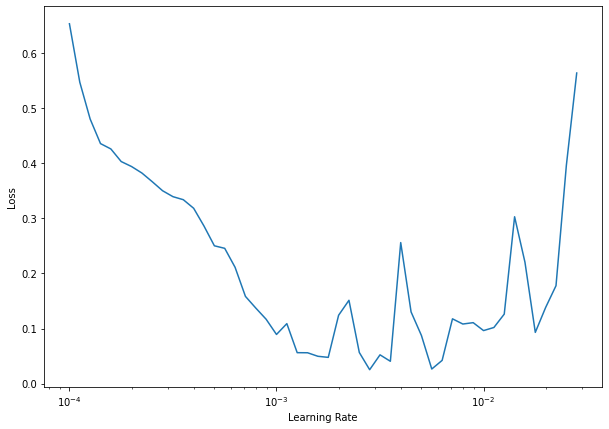

In [ ]:
# Learning rate decay curve
lrs = 1e-4 * (10 **(tf.range(50)/20))
plt.figure(figsize = (10,7))
plt.semilogx(lrs, history_0.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")

Tackling overfitting
---

As seen in model 2's loss curve, the model was exhibiting an overfit. To avoid overfitting we can use some of the following techniques:

1. Incorporating dropout layers between the convolutional layers.
2. Increasing the size of the training data.
3. Augmenting the training data so model sees more iteration of same data for better training.
4. Using stop callback shceduler in the fitting of the model so the model stops training when the validation loss stops declining. 
5. Adding more Maxpool layers 

Right now we can try to reduce model overfit by augmenting the data by incorporating image rotation, shear, zoom, shift and flipping the image. Note that the dataset iteself will not change but during each epoch of training, a random augmented version of the image will be put in. Augmentation leads to more iterations of same data being fed to the CNN model and it would learn diverse patterns; Learning of more patterns makes the model generalizable and thus better validation results. Be careful on how many augmentations should used as too many augmentations can lead to bizzare modification of photos which do not represent real life photos in any way. This also applies to extreme augmentation of the photos as well. Too many augmentations or extreme augmentations leads to CNN learning unwanted patterns e.g. if we zoom in the photos too much CNN would not be able to learn the general patterns like shape of a Pizza.  



In [ ]:
# Import data and augment it from training directory

print("Augment training data & Non-Shuffled:")
train_datagen_aug = ImageDataGenerator(rescale= 1/255.0,
                                       rotation_range = 0.5,
                                       shear_range = 0.2,
                                       zoom_range = [0.7,1.2],
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.1,
                                       horizontal_flip = True)

train_datagen_augmented = train_datagen_aug.flow_from_directory(directory = train_dir,
                                      target_size = (256,256),
                                      class_mode = "binary",
                                      seed = 42,
                                      batch_size = 32,
                                      shuffle = False)

print("Non Augmented training data & Non-Shuffled:")

train_datagen_nonaugmented = train_datagen.flow_from_directory(train_dir,
                                               target_size = (256,256),
                                               batch_size = 32,
                                               class_mode = "binary",
                                               seed = 42,
                                               shuffle = False)

Augment training data & Non-Shuffled:
Found 1500 images belonging to 2 classes.
Non Augmented training data & Non-Shuffled:
Found 1500 images belonging to 2 classes.


13


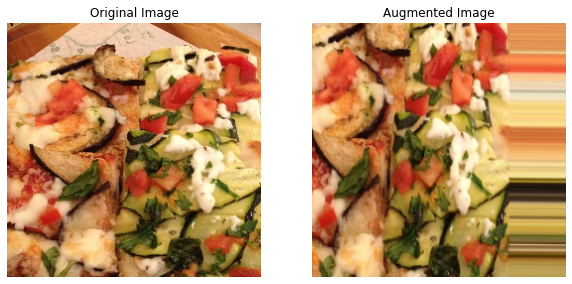

In [ ]:
# Example of data augmentation
images, labels = train_datagen_nonaugmented.next()
augmented_images, augmented_labels = train_datagen_augmented.next()
import random 
random_number = random.randint(0,31)
print(f"{random_number}")
plt.rcParams["figure.figsize"] = (10,10)
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(images[random_number])
plt.axis(False)
plt.subplot(1,2,2)
plt.title(label = "Augmented Image")
plt.imshow(augmented_images[random_number])
plt.axis(False)
plt.show()

Data Augmentation for training 

In [ ]:
# Import data and augment it from training directory

print("Augment training data & Shuffled:")
train_datagen_aug = ImageDataGenerator(rescale= 1/255.0,
                                       rotation_range = 0.5,
                                       shear_range = 0.2,
                                       zoom_range = [0.7,1.2],
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.1,
                                       horizontal_flip = True)

train_datagen_augmented = train_datagen_aug.flow_from_directory(directory = train_dir,
                                      target_size = (256,256),
                                      class_mode = "binary",
                                      seed = 42,
                                      batch_size = 32,
                                      shuffle = True)

print("Non Augmented training data & Shuffled:")

train_datagen_nonaugmented = train_datagen.flow_from_directory(train_dir,
                                               target_size = (256,256),
                                               batch_size = 32,
                                               class_mode = "binary",
                                               seed = 42,
                                               shuffle = True)
print("Non Augmented test data & Shuffled:")
test_datagen = ImageDataGenerator(rescale = 1/255.0)
test_datagen_nonaugmented = test_datagen.flow_from_directory(test_dir,
                                                             target_size = (256,256),
                                                             batch_size = 32,
                                                             class_mode = "binary",
                                                             seed = 42,
                                                             shuffle = True)

Augment training data & Shuffled:
Found 1500 images belonging to 2 classes.
Non Augmented training data & Shuffled:
Found 1500 images belonging to 2 classes.
Non Augmented test data & Shuffled:
Found 500 images belonging to 2 classes.


Model 3 with adjusted learning i.e. rate = 0.0005 and augmented data

In [ ]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu", input_shape = (256,256,3)),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = "valid"),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.Conv2D(filters = 10, kernel_size= 3, 
                           activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), padding = "valid"),   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation = "sigmoid")])  # Activation Sigmoid for binary classification

In [ ]:
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 254, 10)      280       
                                                                 
 conv2d_25 (Conv2D)          (None, 252, 252, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 126, 126, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 124, 124, 10)      910       
                                                                 
 conv2d_27 (Conv2D)          (None, 122, 122, 10)      910       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 61, 61, 10)       0         
 g2D)                                                 

In [ ]:
model_3.compile(loss = tf.keras.losses.binary_crossentropy,
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0005)) # New learning rate

In [ ]:
tf.random.set_seed(42)
history_3 = model_3.fit(train_datagen_augmented, epochs = 10, steps_per_epoch = len(train_datagen_augmented),
            validation_data = test_datagen_nonaugmented, validation_steps = len(test_datagen_nonaugmented))

Epoch 1/10
47/47 [==============================] - 34s 698ms/step - loss: 0.6405 - accuracy: 0.6507 - val_loss: 0.5066 - val_accuracy: 0.7580
Epoch 2/10
47/47 [==============================] - 28s 589ms/step - loss: 0.4787 - accuracy: 0.7760 - val_loss: 0.4813 - val_accuracy: 0.7600
Epoch 3/10
47/47 [==============================] - 31s 667ms/step - loss: 0.4687 - accuracy: 0.7873 - val_loss: 0.3527 - val_accuracy: 0.8360
Epoch 4/10
47/47 [==============================] - 27s 582ms/step - loss: 0.4397 - accuracy: 0.8100 - val_loss: 0.3238 - val_accuracy: 0.8580
Epoch 5/10
47/47 [==============================] - 28s 607ms/step - loss: 0.4421 - accuracy: 0.8000 - val_loss: 0.3242 - val_accuracy: 0.8680
Epoch 6/10
47/47 [==============================] - 27s 581ms/step - loss: 0.4316 - accuracy: 0.8107 - val_loss: 0.3146 - val_accuracy: 0.8700
Epoch 7/10
47/47 [==============================] - 27s 582ms/step - loss: 0.4284 - accuracy: 0.7987 - val_loss: 0.5042 - val_accuracy: 0.7320

✌**Using augmented data has increased the validation accuracy by 2% and reduced the validation loss by 8% in the same 10 epochs. Thus our model has been able to discern patterns between pizza and steak in a better way and model is more generalizable.** 

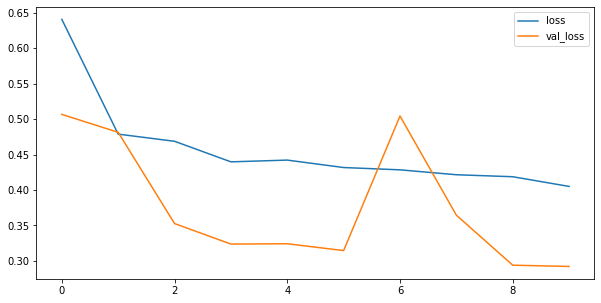

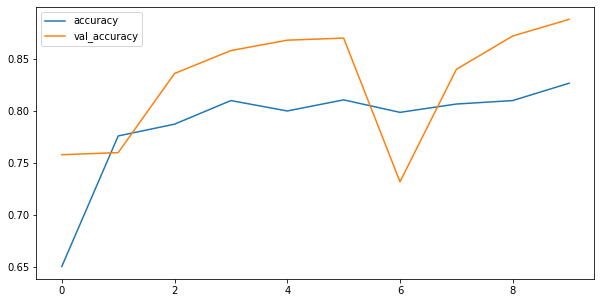

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
pd.DataFrame(history_3.history)[["loss", "val_loss"]].plot()
pd.DataFrame(history_3.history)[["accuracy", "val_accuracy"]].plot()

Using the last model we can create classification prediction on custom images of our own. Note that the picture needs to be rescaled to the same ratio that the model was trained on i.e. 256 x 256. Also other similar preprocessing steps need to be applied e.g. normalization and batch conversion. 

In [ ]:
# Function for importing custom images and reshaping them as per the model

def import_and_prep_image(filename, img_shape = 256):
  """
  Reshapes the imported images to go with the state of the model.
  """

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  img = img/255.0
  img = tf.expand_dims(img, axis = 0)
  return img


# Function to visualize custom predictions and  

def custom_prediction(model, imported_image):
  import matplotlib.pyplot as plt
  preped_image = import_and_prep_image(filename = imported_image, img_shape = 256)
  pred_prob = model.predict(preped_image)
  if pred_prob > 0.5:
    custom_image = "Steak"
  else:
    custom_image = "Pizza"  
  plt.imshow(tf.squeeze(preped_image))
  np_convert = tf.squeeze(pred_prob).numpy()
  rounded_pred = round(number = np_convert, ndigits = 3)
  plt.title("Prediction Probability: {:.2f} = {:s} ".format(rounded_pred, custom_image))
  plt.axis(False)

MOMENT OF TRUTH
---

To test the model two pictures have been used. One is an image of a Pizza I had ordered and the second picture is of Steak that I have downloaded from an online resource. 



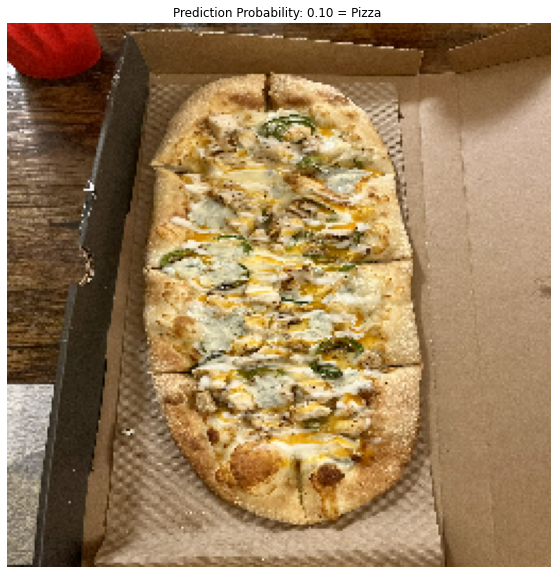

In [ ]:
imported_image_1 = "IMG-7585.jpg"
plt.rcParams["figure.figsize"] = (10,10)
custom_prediction(model_3, imported_image_1)

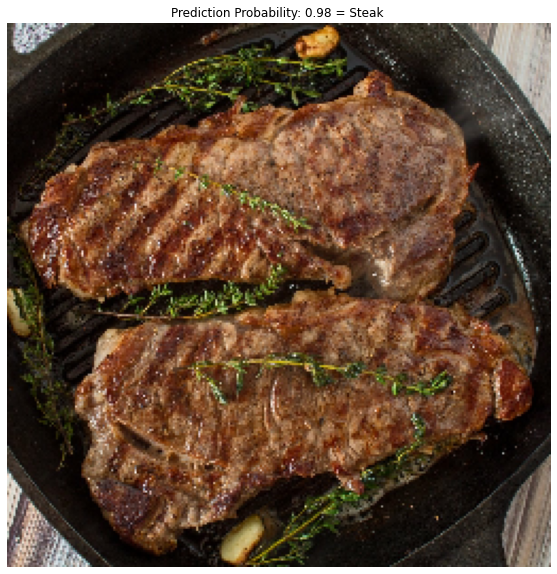

In [ ]:
imported_image_2 = "steak.jpg"
plt.rcParams["figure.figsize"] = (10,10)
custom_prediction(model_3, imported_image_2)

Conclusion
---

The decision boundary for sigmoid activation in the output layer was set to 0.5 meaning if prediction probability is close to 0 it is more likely that prediction would be of a Pizza. If the prediction probility is close to 1 the more likely it is that the prediction would be that of a Steak. 

🥇 In both predictions, their respective probabilities are very close to the sigmoid min and max. Thus giving satisfactory results.

The model created is in no way close to perfection but is generalizable to enough to give accurate predictions on these two classes. More methods can be used to reduce the overfitting. Similarly, more complex models can be used to get even better validation results.  
